# Detection and replacement of OUTLIERS

## First approach - using the first derivative

The first approach we tried was based on the characteristic that a single outlier is a value that changes so fast in relation to the two values that surround it. Thus, if we consider the first derivative, an outlier will be surrounded by two “big” derivative values, one positive and the other negative. 

We established that those “big” derivative values must be bigger than the mean derivative of the profile plus 5 times its standard deviation (we established 5 because if we reduced this number the approach detected too many outliers).

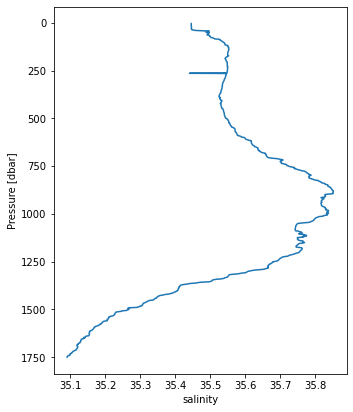

In [24]:
#Code of the 1st approach to detect and replace Outliers - zpau - 02/02/2022
#First, some imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate
import plotting_functions as plot

#Now we read the data
from read_CTD import read_CTD
data_dirs = ['C:/Users/Pau/Data/TFM/CTD_proc_files_1mbin/']
data=read_CTD(data_dirs)

#We will work with the example of the salinity vertical profile number ncast='41'
#Let's see its form
ncast = '41'
variable = 'salinity'
data[ncast][variable].plot_cast()
plt.show()

Text(0.5, 1.0, '1st derivative')

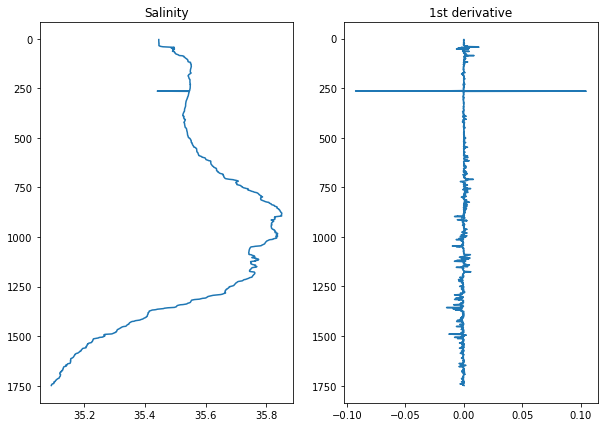

In [25]:
#We observe an evident outlier at around 250 dbar
#First, we get the array of salinity values and the array of pressure values
var = data[ncast][variable].values
pres = np.array(data[ncast].index)
#Now, we calculate the first derivative
dvar = np.diff(var)
dpres = np.diff(pres)
der_var = dvar/dpres
#Now we plot the salinity vertical profile and the derivative vertical profile
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10,7))
ax0.plot(var, pres)
ax0.invert_yaxis()
ax0.set_title('Salinity')
ax1.plot(der_var, pres[1:])
ax1.invert_yaxis()
ax1.set_title('1st derivative')

In [26]:
#We see that the 1st derivative detects apparently well the outlier
#Now we find the index of the outlier
#We establish that to be considered an outlier, the derivative value must be bigger than the mean derivative plus 5 times de derivative std
ind_outliers = np.where((der_var>der_var.mean()+5*der_var.std())|(der_var<der_var.mean()-5*der_var.std()))[0]

#As we are trying to find single outliers, each outlier will be between two big derivative values (one positive other negative)
#So, we group the index in groups of two
#(In this case, as we have just 1 single outlier, we could avoid this)
ind_outliers = ind_outliers.reshape(len(ind_outliers)//2,2)
print('The outlier is between indexs: ',ind_outliers)

#We see that the outlier is between the derivative index 257 (point 257 to point 258) and 258 (point 258 to point 259)
#So the outlier is the salinity value in the 258 index (35.441 psu)
print('The variable value of the outlier is: ',var[258])

#The following code gets the outlier point and changes its value to a value interpolated between its surroundigs points
for i in ind_outliers:   #For each group of the outliers
    var_interp = scipy.interpolate.interp1d((pres[i[0]], pres[i[1]+1]),(var[i[0]], var[i[1]+1]))   #Creates the interpolation function
    var[i[1]] = var_interp(pres[i[1]])     #Changes the outlier value to an interpolated one
    print('The new value is: ',var[i[1]])

The outlier is between indexs:  [[257 258]]
The variable value of the outlier is:  35.441
The new value is:  35.54049692917286


<AxesSubplot:xlabel='salinity', ylabel='Pressure [dbar]'>

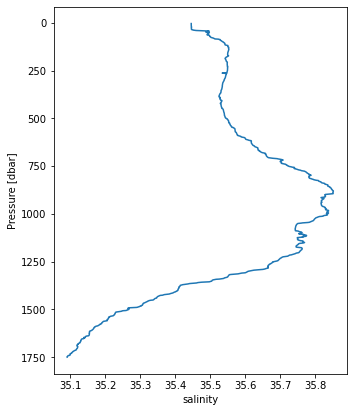

In [28]:
#Now we change the old values of salinity (with single outliers) to the new ones (without single outliers)
data[ncast][variable] = var

#And plot the new vertical profile
data[ncast][variable].plot_cast()

In [29]:
#We can see that the single outlier that was around 250dbar has dissapeared
#Now we will generalize the process to do it with all the stations and variables needed
def outliers_out(data, ncast, variable):
    """Remove single outliers from a vertical
    profile of a variable of a particular station
    data = dict with de CTD data
    ncast = number od the cast of the station
    variable = name of the variable"""
    import pandas as pd
    import numpy as np
    import scipy.interpolate
    
    var=data[ncast][variable].values
    pres = np.array(data[ncast].index)
    der_var = np.diff(var)/np.diff(pres)
    
    ind_outliers = np.where((der_var>(der_var.mean()+15*der_var.std()))|(der_var<(der_var.mean()-15*der_var.std())))[0]
    ind_outliers = ind_outliers.reshape(len(ind_outliers)//2,2)
    
    for i in ind_outliers:
        var_interp = scipy.interpolate.interp1d((pres[i[0]], pres[i[1]+1]),(var[i[0]], var[i[1]+1]))
        var[i[1]] = var_interp(pres[i[1]])

This first approach was appropriate to detect single outliers, however, it had some weak points as it does not correctly detect outliers that are grouped. Thus, we tried to find another approach